# Extract Sensitivity Dataset

In [ ]:
!pip install datasets
!pip install huggingface_hub

In [2]:
import json
import random
import pandas as pd
import numpy as np
import re
from datasets import load_dataset

In [ ]:
from huggingface_hub import login

# Replace 'your_api_token_here' with your actual Hugging Face API token
login(token="your_api_token_here")

## Load FOLIO

In [ ]:
# Load the dataset
dataset = load_dataset("yale-nlp/FOLIO")

# Convert the train split to a DataFrame
train_df = dataset["train"].to_pandas()

# Convert the test split to a DataFrame
test_df = dataset["validation"].to_pandas()

In [5]:
print(f'Train: {len(train_df)}')
print(f'Test: {len(test_df)}')

Train: 1001
Test: 203


## Sample extraction

*   Get unique records
*   Use only Premise FOL since these are the generation records. Conclusion FOL have inconsistent predicates.
*   Test on training data only as we aim to build an evaluation system that can identify the changes in FOL



In [6]:
# Get unique records
train_df.drop_duplicates(subset='story_id', inplace=True)

In [7]:
# Split NL and FOL
train_df['premisesFOL'] = train_df['premises-FOL'].apply(lambda x: x.strip('\n').split('\n'))
train_df['premisesNL'] = train_df['premises'].apply(lambda x: x.strip('\n').strip().split('\n'))
train_df['premisesFOL_count'] = train_df['premisesFOL'].apply(lambda x: len(x))
train_df['premisesNL_count'] = train_df['premisesNL'].apply(lambda x: len(x))

In [8]:
# Verify correctness
train_df[train_df['premisesFOL_count']!=train_df['premisesNL_count']]

,story_id,premises,premises-FOL,conclusion,conclusion-FOL,label,example_id,premisesFOL,premisesNL,premisesFOL_count,premisesNL_count


In [9]:
def count_operators(fol):
  # Define the regex pattern for operators
  pattern = r'[∧∨¬→↔∀∃=⊕]'

  # Find all matches of operators
  matches = re.findall(pattern, fol)

  # Count the number of operators
  num_operators = len(set(matches))
  return num_operators

In [10]:
def get_operators(fol):
  # Define the regex pattern for operators
  pattern = r'[∧∨¬→↔∀∃=⊕]'

  # Find all matches of operators
  matches = re.findall(pattern, fol)

  # Count the number of operators
  operators = set(matches)
  return operators

In [11]:
# Operator check at passage level
train_df['num_operators'] = train_df['premises-FOL'].apply(count_operators)
train_df['operators'] = train_df['premises-FOL'].apply(get_operators)

In [12]:
# Extract unique operator FOLs
train_df.drop_duplicates(subset='operators', inplace=True)

In [13]:
# Convert to individual statements
df_expanded = train_df[['premisesFOL', 'premisesNL']].apply(pd.Series.explode)
print(f'Data size: {len(df_expanded)}')

Data size: 225


In [14]:
# Operator check at sentence level
df_expanded['operators'] = df_expanded['premisesFOL'].apply(get_operators)
print(f'Unique operators: {len(df_expanded.drop_duplicates(subset="operators"))}')

Unique operators: 52


In [15]:
# Convert sets to frozensets for grouping
df_expanded['unique_ops'] = df_expanded['operators'].apply(frozenset)

# Set the maximum number of duplicates to keep
max_dups = 4

# Use groupby and cumcount to filter out rows with more than `max_dups` occurrences
df_limited_dups = df_expanded[df_expanded.groupby('unique_ops').cumcount() < max_dups]

# Drop the frozenset column used for grouping
df_result = df_limited_dups.drop(columns=['unique_ops'])

print(f'Final data size: {len(df_result)}')

Final data size: 103


In [16]:
df_result['count'] = df_result['operators'].apply(len)

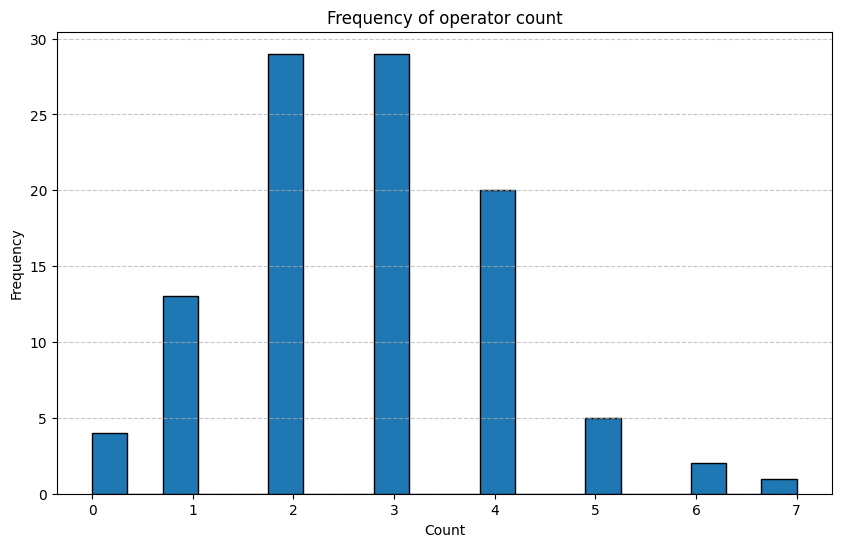

In [17]:
from matplotlib import pyplot as plt
# Plotting the occurence of operators
plt.figure(figsize=(10, 6))
plt.hist(df_result['count'], bins=20, edgecolor='black')
plt.title('Frequency of operator count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# Save dataset

df_result.reset_index(drop=True, inplace=True)

df_result.to_json("sensitivity.json", orient="records", indent=4)